# Initials

## Import

In [1]:
#Import libraries for simulation
import tensorflow as tf
import numpy as np

#Imports for visualization
import PIL.Image
from io import BytesIO
from IPython.display import clear_output, Image, display

from skimage.draw import circle, rectangle

In [2]:
sess = tf.InteractiveSession()

## Utility functions

In [3]:
# likely also fine to use matplotlib's imshow?
# TODO: Need to be able to save these movies instead of displaying them

def DisplayArray(a, fmt='jpeg', rng=[0,1]):
  """Display an array as a picture."""
  a = (a - rng[0])/float(rng[1] - rng[0])*255
  a = np.uint8(np.clip(a, 0, 255))
  f = BytesIO()
  PIL.Image.fromarray(a).save(f, fmt)
  clear_output(wait = True)
  display(Image(data=f.getvalue()))

In [7]:
def make_kernel(a):
    """Transform a 2D array into a convolution kernel"""
    a = np.asarray(a)
    a = a.reshape(list(a.shape) + [1,1])
    return tf.constant(a, dtype=1)

def periodic_padding(image, padding=1):
    ''' Emulate periodic boundary conditions '''
    if padding==0:
        return image
    upper_pad = image[-padding:,:]
    lower_pad = image[:padding,:]
    partial_image = tf.concat([upper_pad, image, lower_pad], axis=0)
    
    left_pad = partial_image[:,-padding:]
    right_pad = partial_image[:,:padding]
    padded_image = tf.concat([left_pad, partial_image, right_pad], axis=1)
    
    return padded_image

def simple_conv(x, k, padding=1):
    """A simplified 2D convolution operation"""
    x = periodic_padding(x, padding)
    x = tf.expand_dims(tf.expand_dims(x, 0), -1)
    y = tf.nn.depthwise_conv2d(x, k, [1, 1, 1, 1], padding='SAME')
    return y[0, padding:-padding, padding:-padding, 0]

def laplace(x):
    """Compute the 2D laplacian of an array"""
    laplace_k = make_kernel([[0.5, 1.0, 0.5],
                            [1.0, -6., 1.0],
                            [0.5, 1.0, 0.5]])
    return simple_conv(x, laplace_k)

# Simulations

## Pond
"A (somewhat pedestrian) example of using TensorFlow for simulating the behavior of a partial differential equation. We'll simulate the surface of square pond as a few raindrops land on it."

In [5]:
N = 500

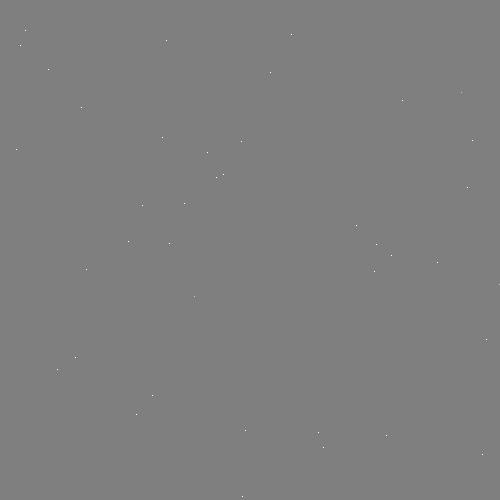

In [51]:
# Initial Conditions -- some rain drops hit a pond

# Set everything to zero
u_init = np.zeros([N, N], dtype=np.float32)
ut_init = np.zeros([N, N], dtype=np.float32)

# Some rain drops hit a pond at random points
for n in range(40):
  a,b = np.random.randint(0, N, 2)
  u_init[a,b] = np.random.uniform()

DisplayArray(u_init, rng=[-0.1, 0.1])

In [52]:
# Parameters:
# eps -- time resolution
# damping -- wave damping
eps = tf.placeholder(tf.float32, shape=())
damping = tf.placeholder(tf.float32, shape=())

# Create variables for simulation state
U  = tf.Variable(u_init)
Ut = tf.Variable(ut_init)

# Discretized PDE update rules
U_ = U + eps * Ut
Ut_ = Ut + eps * (laplace(U) - damping * Ut)

# Operation to update the state
step = tf.group(U.assign(U_), Ut.assign(Ut_))

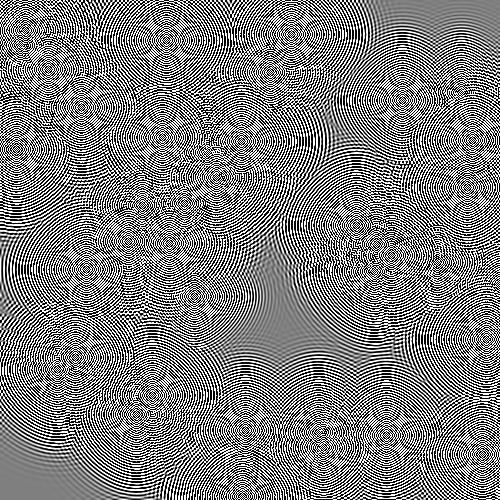

In [53]:
# Initialize state to initial conditions
tf.global_variables_initializer().run()

# Run 1000 steps of PDE
for i in range(1000):
    # Step simulation
    step.run({eps: 0.03, damping: 0.04})
    DisplayArray(U.eval(), rng=[-0.1, 0.1])

## Gray-Scott
https://mrob.com/pub/comp/xmorphia/pearson-classes.html

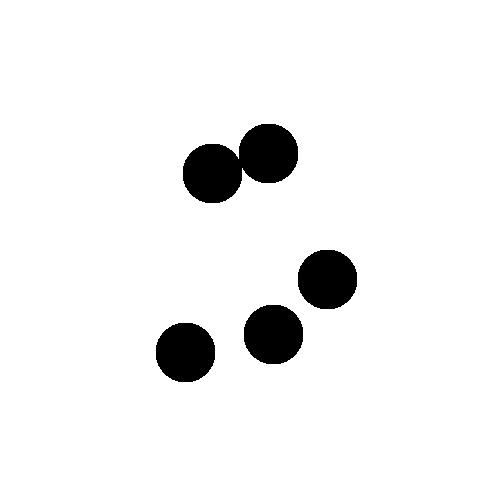

In [8]:
N = 500

# Set U to one for fuel, V to zero except some spots
u_init = np.ones([N, N], dtype=np.float32)
v_init = np.zeros([N, N], dtype=np.float32)

for n in range(5):
    a,b = np.random.randint(N/4, 3*N/4, 2)
    rr, cc = circle(a, b, 30, shape=(N,N))
    v_init[rr, cc] = 1
# size = 20
# rr, cc = rectangle((N//2-size, N//2-size), end=(N//2+size, N//2+size), shape=(N,N))
# u_init[rr, cc] = 1/2
# v_init[rr, cc] = 1/4


DisplayArray(1-v_init, rng=[0, 1])

In [9]:
# Parameters:
# eps -- time resolution
# damping -- wave damping
dt = tf.placeholder(tf.float32, shape=())
dx = tf.placeholder(tf.float32, shape=())
a = tf.placeholder(tf.float32, shape=())
b = tf.placeholder(tf.float32, shape=())
k = tf.placeholder(tf.float32, shape=())
f = tf.placeholder(tf.float32, shape=())

# Create variables for simulation state
U  = tf.Variable(u_init)
V  = tf.Variable(v_init)

# Discretized PDE update rules
U_ = U + dt*(a*laplace(U) - U*V*V + f*(1-U))
V_ = V + dt*(b*laplace(V) + U*V*V - (k+f)*V)

# Operation to update the state
step = tf.group(U.assign(U_), V.assign(V_))

### Exploring patterns 

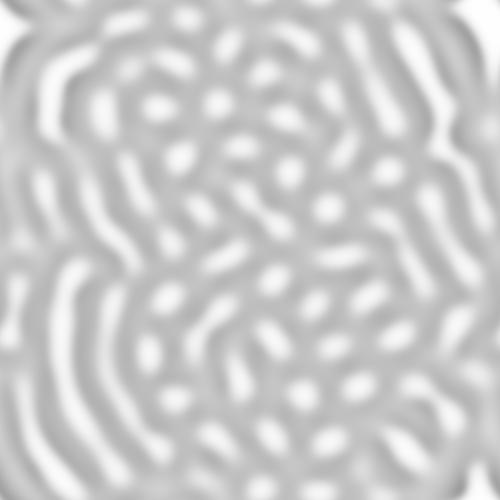

In [14]:
tf.global_variables_initializer().run()

for i in range(10000):
    # Type delta (δ)
    step.run({dt: 0.15, a: 1, b: 0.5, f: 0.03, k: 0.055})
    if i%100==0:
        DisplayArray(1-V.eval(), rng=[0, 1])

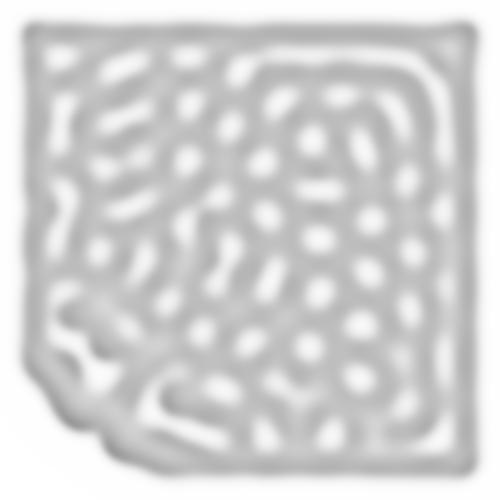

In [11]:
tf.global_variables_initializer().run()

for i in range(10000):
    # Type delta (δ)
    step.run({dt: 0.15, a: 1, b: 0.5, f: 0.03, k: 0.055})
    DisplayArray(1-V.eval(), rng=[0, 1])

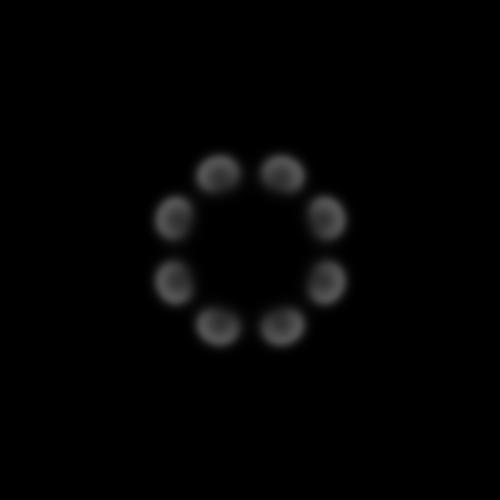

In [28]:
tf.global_variables_initializer().run()

for i in range(5000):
    # Type epsilon (ε)
    step.run({dt: 0.15, a: 1, b: 0.5, k: 0.055, f: 0.018})
    DisplayArray(V.eval(), rng=[0, 1])

### Patterns to compare

There is a core of patterns that are nearly identical. These are:

Type kappa (κ)
- Stripes in isolation grow width-wise (usually by developing meanders to grow longer and more serpentine); some irregular blue shapes grow into corals. The final state is mostly all stripes, often with branching, and usually in multiple disjoint sets (hedgerow mazes).
- (F=0.050, k=0.063) / (F=0.058, k=0.063)

Type theta (θ) 
- differs from this by having a stable blue state, and stripes that are more likely to join.
- (F=0.030, k=0.057) / (F=0.038, k=0.061)

Type mu (μ) 
- differs from this by the fact that small blue spots turn into a worm, rather than growing out in all directions to form a ring or coral.
- (F=0.046, k=0.065) / (F=0.058, k=0.065)

Type eta (η)
- differs from this by having shorter stripes/worms and many solitons, and oscillation in the ∂u/∂t component.
- (F=0.034, k=0.063)

Type gamma (γ)
- Stripes, either wormlike or branching, with endless instability in the form of occasional changes due to overcrowding, grain boundary instabilities, or other localised events, and oscillation in the ∂u/∂t component.
- (F=0.022, k=0.051), (F=0.026, k=0.055)

#### Theta

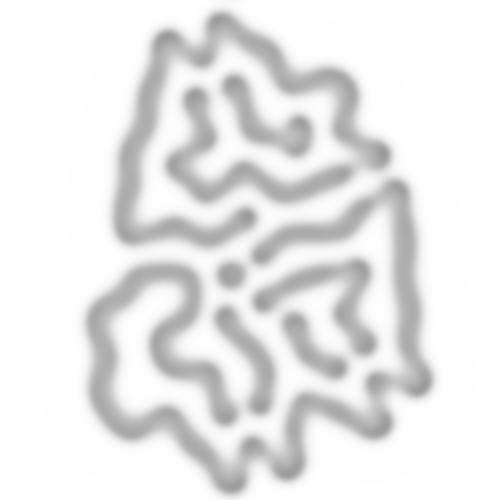

In [16]:
# Type theta (θ)
tf.global_variables_initializer().run()

result_t1 = []
for i in range(10000):
    step.run({dt: 0.19, a: 1, b: 0.5, f: 0.038, k: 0.061})
    if i%100 == 0:
        tmp = V.eval()
        result_t1.append([i,tmp])
    DisplayArray(1-tmp, rng=[0, 1])

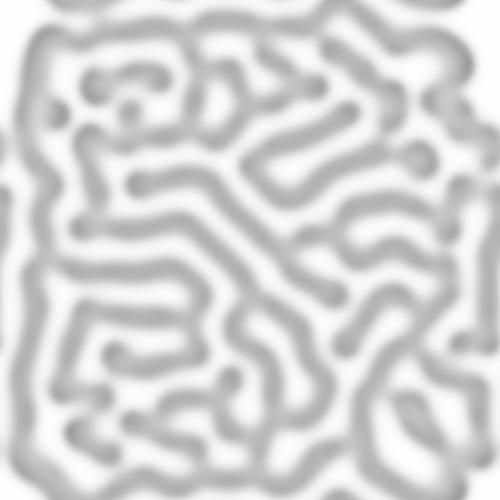

In [24]:
# Type theta (θ)
tf.global_variables_initializer().run()

result_t2 = []
for i in range(10000):
    step.run({dt: 0.19, a: 1, b: 0.5, f: 0.030, k: 0.057})
    if i%100 == 0:
        tmp = V.eval()
        result_t2.append([i,tmp])
    DisplayArray(1-tmp, rng=[0, 1])

#### Kappa

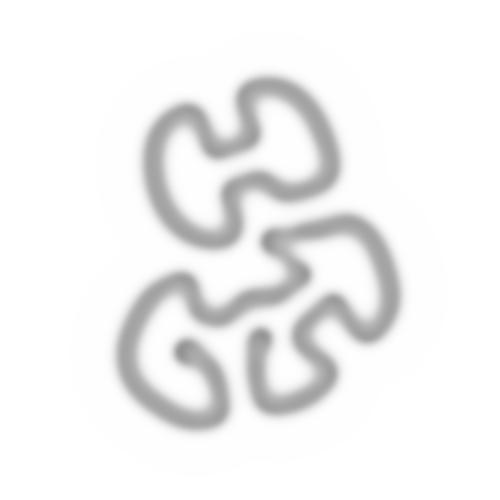

In [18]:
# Type kappa
tf.global_variables_initializer().run()

result_k1=[]
for i in range(10000):
    step.run({dt: 0.19, a: 1, b: 0.5, f: 0.050, k: 0.063})
    if i%100 == 0:
        tmp = V.eval()
        result_k1.append([i,tmp])
    DisplayArray(1-tmp, rng=[0, 1])

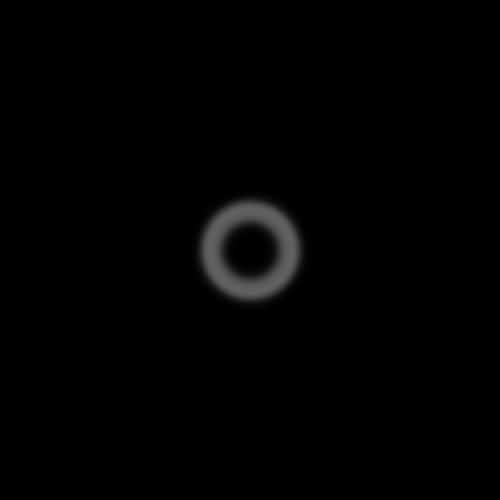

In [34]:
# Type kappa
tf.global_variables_initializer().run()

for i in range(10000):
    step.run({dt: 0.19, a: 1, b: 0.5, f: 0.058, k: 0.063})
    DisplayArray(V.eval(), rng=[0, 1])

#### Eta

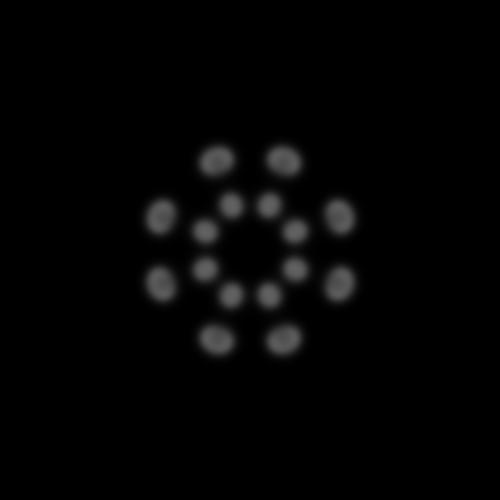

In [35]:
# Type eta
tf.global_variables_initializer().run()

for i in range(10000):
    step.run({dt: 0.19, a: 1, b: 0.5, f: 0.034, k: 0.063})
    DisplayArray(V.eval(), rng=[0, 1])

#### Mu

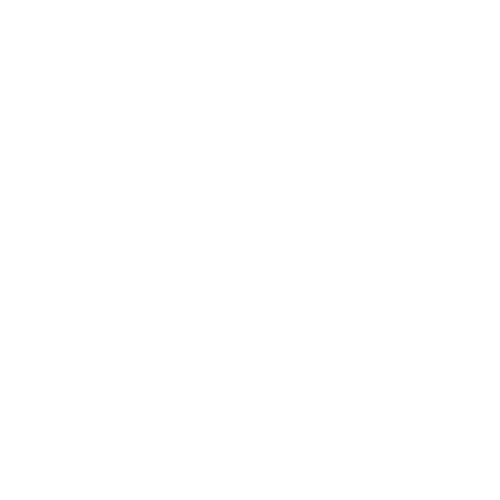

KeyboardInterrupt: 

In [20]:
# Type mu
tf.global_variables_initializer().run()

result_m1 = []
for i in range(10000):
    step.run({dt: 0.19, a: 1, b: 0.5, f: 0.046, k: 0.065})
    if i%100 == 0:
        tmp = V.eval()
        result_m1.append([i,tmp])
        DisplayArray(1-tmp, rng=[0, 1])

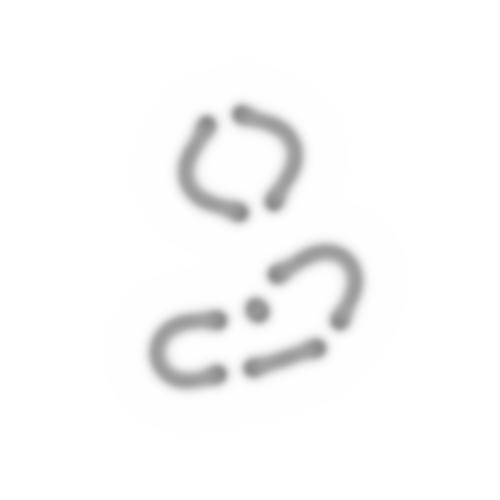

In [21]:
# Type mu
tf.global_variables_initializer().run()

result_m2 = []
for i in range(10000):
    step.run({dt: 0.19, a: 1, b: 0.5, f: 0.058, k: 0.065})
    if i%100 == 0:
        tmp = V.eval()
        result_m2.append([i,tmp])
        DisplayArray(1-tmp, rng=[0, 1])

#### Gamma

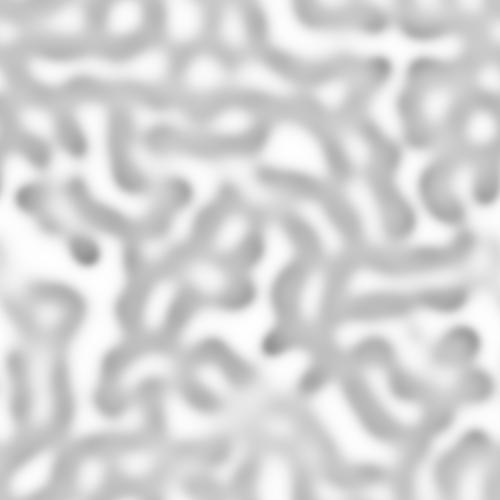

In [19]:
# Type gamma
tf.global_variables_initializer().run()

result_g1 = []
for i in range(10000):
    step.run({dt: 0.19, a: 1, b: 0.5, f: 0.022, k: 0.051})
    if i%100 == 0:
        tmp = V.eval()
        result_g1.append([i,tmp])
        DisplayArray(1-tmp, rng=[0, 1])

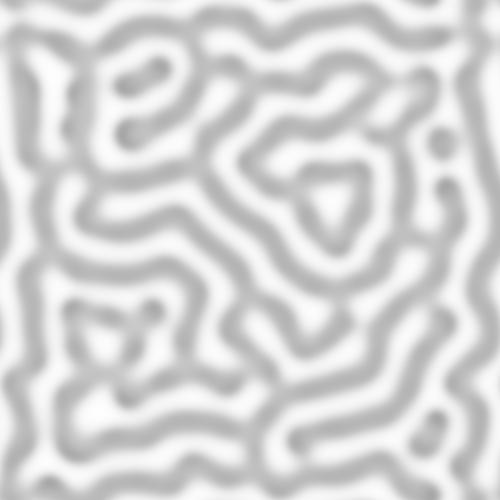

In [25]:
# Type gamma
tf.global_variables_initializer().run()

result_g2 = []
for i in range(10000):
    step.run({dt: 0.19, a: 1, b: 0.5, f: 0.026, k: 0.055})
    if i%100 == 0:
        tmp = V.eval()
        result_g2.append([i,tmp])
        DisplayArray(1-tmp, rng=[0, 1])

In [30]:
import pickle
from os.path import join
def save_obj(obj, name, root=''):
    with open(join(root, '.obj', name + '.pkl'), 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [31]:
save_obj('gamma_f_026_k_055', result_g2)

TypeError: can only concatenate list (not "str") to list